In [1]:
URL = "chals.sekai.team:3023"
FLAG2 = "SEKAI{3ff1c13nt_GES_4_Shortest-Path-Queries-_-}"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

CONNECTED
============ MENU ============
1. Graph Information
2. Query Responses
3. Challenge
4. Exit
> Option: [!] Graph information:
============ MENU ============
1. Graph Information
2. Query Responses
3. Challenge
4. Exit


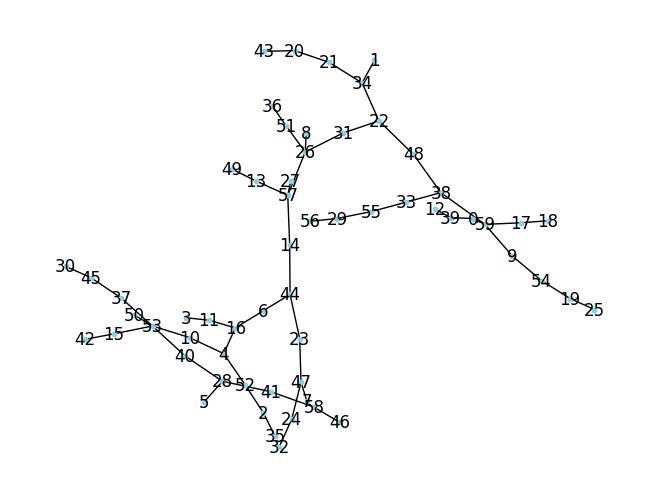

Graph with 60 nodes and 59 edges
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}


In [3]:
import utils
import socket
import sys
import time
import functools
import json
from collections import defaultdict 
import networkx as nx

NODE_COUNT = 60
SECURITY_PARAMETER = 128

class CryptoClient:
    def __init__(self, connection: str):
        self.ip, self.port = connection.split(":")
        self.port = int(self.port)
        self.sock = None
        self.buffer = ""  # Initialize an empty buffer

    def connect(self):
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        try:
            self.sock.connect((self.ip, self.port))
        except ConnectionError:
            print("Failed to connect to server.")
            sys.exit(1)
        print("CONNECTED")

    def read_line(self):
        while "\n" not in self.buffer:
            try:
                data = self.sock.recv(1 ** 20).decode('utf-8')
                if not data:
                    return None
                self.buffer += data
            except socket.error:
                return None
        line, self.buffer = self.buffer.split("\n", 1)
        return line
    
    def skip_until(self, text, debug=True):
        time.sleep(1)
        while True:
            line = self.read_line()
            if debug and line:
                print(line)
            if line and text in line:
                break
                
    def receive_value(self):
        line = self.read_line()
        if line:
            value = line.split(':')[-1].strip()
        else:
            print("Failed to receive data from server.")
            sys.exit(1)
        return value

    def receive_query(self):
        line = self.read_line()
        if line:
            values = line.split(': ')[-1].split()
            query_from, query_to = map(int, values)
        else:
            print("Failed to receive data from server.")
            sys.exit(1)
        print(f"QUERY: {query_from} -> {query_to}")
        return query_from, query_to

    def get_hex_value(self):
        line = self.read_line()
        if line:
            try:
                value = bytes.fromhex(line.split(': ')[-1].strip())
            except ValueError as e:
                print(line)
                raise
        else:
            print("Failed to receive data from server.")
        return value
    
    def receive_response(self, debug=False):
        response = self.get_hex_value()
        if debug:
            print(f"RESPONSE: {response.hex()}")    
        return response
    
    def receive_token(self, debug=False):
        token = self.get_hex_value()
        if debug:
            print(f"TOKEN: {token.hex()}")    
        return token
    
    def send_response(self, response: str, debug=False):
        try:
            self.sock.sendall((response + "\n").encode('utf-8'))
        except socket.error:
            print("Failed to send data to server.")
            sys.exit(1)
        if debug:
            print(f"SENT RESPONSE: {response}")


def decrypt(u: int, v: int, key: bytes, resp: bytes) -> str:
    """
    Decrypts the response to reveal the shortest path between nodes in the graph.

    Parameters:
    u (int): The source node
    v (int): The destination node
    resp (bytes): The encrypted response from the server
    key (bytes): The secret key used for decryption

    Returns:
    str: The decrypted shortest path as a space-separated string
    """
    # Extract Subkeys
    key_SKE = key[:16]
    key_DES = key[16:]
    
    # Initialize Variables
    path = [u]
    # Decryption Loop
    segment_size = 32  # Assuming each encrypted node is 32 bytes
    for i in range(0, len(resp), segment_size):
        # Decrypt the segment
        block = resp[i:i+segment_size]
        decrypted_segment = utils.SymmetricDecrypt(key_SKE, block)
        
        # Path Extraction
        # Assuming decrypted_segment contains the node as bytes
        node1, node2 = map(int, decrypted_segment.decode().split(','))
        path.append(node1)
        
    # Validate the path starts at 'u' and ends at 'v'
    if path[0] != u or path[-1] != v:
        return "Invalid path"
    
    # Return Result
    return " ".join(map(str, path))

# tokens = []
# search_tokens = []
# responses = []

# path_from = {}
chunk_ids = {}
def get_id(s):
    chunk_ids[s] = chunk_ids.get(s, len(chunk_ids))
    return chunk_ids[s]

SIZE = 64
def enumerate_unique(string):
    numbers = []
    assert len(string) % SIZE == 0
    for i in range(len(string) // SIZE):
        chunk = string[i * SIZE: (i + 1) * SIZE]
        numbers.append(get_id(chunk))

    return numbers

def str_enumerate_unique(string):
    return ','.join([str(n) for n in enumerate_unique(string)])

    
debug = False
client = CryptoClient(URL)
client.connect()
client.send_response(FLAG2)
client.skip_until('Recover 10 queries', debug=False)
client.send_response('1')  
client.skip_until('Graph information')
edges = client.receive_value()
client.skip_until('============================')

edges = eval(edges)
graph = nx.Graph()
graph.add_nodes_from(range(NODE_COUNT))
graph.add_edges_from(edges)

pos = nx.spring_layout(graph, seed=42)


# Draw the graph
nx.draw(graph, pos, with_labels=False, node_color='skyblue', edge_color='black', node_size=10, font_size=15)

# Draw the labels using the same positions
nx.draw_networkx_labels(graph, pos, labels={node: str(node) for node in graph.nodes()})

plt.show()

print(graph)
for component in nx.connected_components(graph):
    print(component)

In [4]:
client.send_response('2') 
client.skip_until('Query Responses')

all_tokens = []
while True:
    tokens_response = client.receive_value()
    # print(tokens_response)
    if "MENU" in tokens_response:
        break
    else:
        try:
            parts = tokens_response.split(' ')
            tokens, response = [], []
            if len(parts) == 1:
                tokens = parts[0]
            elif len(parts) == 2:
                tokens, response = parts
            else:
                raise ValueError('Wrong format')
            all_tokens.append(enumerate_unique(tokens))
        except ValueError:
            print(f'"{tokens_response}"')
            raise
        str_enumerate_unique(tokens)

> Option: [*] Query Responses: 


In [5]:
import itertools
    
def get_stable_sequence_for_pathes(pathes_with_same_end):
    def get_stable_sequence(current_root, children):
        current_children = children[current_root]
        sequences = [
            [(len(current_children), current_root)]
        ]
        # print("ROOT:", sequences[0])
        if len(current_children) > 0:
            child_sequences = [get_stable_sequence(child, children) for child in current_children]
            # print(child_sequences[0][0])

            # print("CHILDREN:", child_sequences)
            child_sequences = list(sorted(
                child_sequences, 
                key=lambda s: [x[0] for x in s] # starting from sequence with least children  
            ))

            # parent is always first, after it it's child starting with least children (recursively)
            sequences.extend(child_sequences)
        sequence = list(itertools.chain.from_iterable(sequences))
        # print("RESULT: ", sequence)
        return sequence
    pathes_with_same_end = sorted([path[::-1] for path in pathes_with_same_end], key = lambda x: len(x))

    children = defaultdict(set)
    root = pathes_with_same_end[0][0]
    for path in pathes_with_same_end:
        for a, b in zip(path, path[1:]):
            children[a].add(b)

    signature, ids = zip(*get_stable_sequence(root, children))
    return signature, ids


In [6]:
stable_structure_signatures = {}

shortest_paths = nx.all_pairs_shortest_path(graph)
for start, paths in shortest_paths:
    shortest_paths_same_end = [
        [(x, start) for x in path[::-1]]
        for _, path in paths.items()    
    ]
    signature, ids = get_stable_sequence_for_pathes(shortest_paths_same_end)
    print(signature)
    stable_structure_signatures[signature] = ids
    
assert(len(stable_structure_signatures)) == 60

(2, 1, 0, 3, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 3, 0, 1, 0, 3, 0, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 4, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0)
(1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0, 3, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 3, 0, 1, 0, 3, 0, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 4, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0)
(2, 0, 1, 2, 1, 4, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 3, 0, 1, 0, 3, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 3, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0)
(1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 1, 3, 0, 1, 0, 3, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 3, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 2, 1, 1, 0, 1, 4, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0)
(3, 1, 1, 0, 1, 4, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 3, 0, 1, 0, 3, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 3, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0)
(1, 2, 1, 1, 0, 1, 4, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 3, 0, 1

In [7]:
def get_mapping(stable_structure_signatures, test_pathes):
    signature, ids = get_stable_sequence_for_pathes(test_pathes)
    mapping = {
        h: (u, v)
        for (u, v), h in zip(stable_structure_signatures[signature], ids)
    }
    return mapping

In [8]:
ends = set([tokens[-1] for tokens in all_tokens])

In [9]:
from collections import ChainMap
all_mappings = []
for end in ends:
    test_pathes = [tokens for tokens in all_tokens if tokens[-1] == end]
    all_mappings.append(
        get_mapping(stable_structure_signatures, test_pathes)
    )
    
all_mappings = ChainMap(*all_mappings)
len(all_mappings)

3600

In [10]:
client.send_response('3')
for _ in range(10):
    client.skip_until('[+] Challenge')
    token = client.receive_token()
    search_token_response = client.receive_response()
    response_len = len(search_token_response)
    search_token = search_token_response[:response_len // 2]
    response = search_token_response[response_len // 2:]
    
    path = token.hex() + search_token.hex()
    print(path)
    ids = enumerate_unique(path)
    path_decrypted = [
        all_mappings[i][0] for i in ids
    ]
    print([all_mappings[i] for i in ids])
    client.send_response(' '.join([str(n) for n in path_decrypted]), debug=True)

1. Graph Information
2. Query Responses
3. Challenge
4. Exit
> Option: [!] In each query, input the shortest path decrypted from response. It will be a string of space-separated nodes from source to destination, e.g. '1 2 3 4'.
[+] Challenge 1/10.
5444febb0703861f41733f07bd6d1f8e40fa01cff13af293020d04c6102f1e393a8142edb4d30791461fa20b5bd12f18fc5178aece314e2a5276af6c07addbf144d93776835a28573486ff3bc1c7136a13894631d230fe1d7b499264cf56099f10f73729cc05cbfce688b6f4b120ac263b465d3e235f35a6c195630cdf2b327822d1523979bc74dcb42a20e2d0ba451691f40c3398d052a33c10c79c119c08182f469925ade0cd3511c07880f275891fb5bcc269f5507d9df5b09f243912f59bac74751e8911df14e50582197b0dbb7cb47c2bbebedf82c1b58479bdcddef5d72c1bfc170971023fc15815d63c635831fb4ecee0f4a3caffba147fa9ea72f03c92391a731472a23ed754fd79cbf609593281e95bbf44f1564fd38067a46cf08a4f446054a0275765b2c6aced767f960e34f6f3b92efc4e0a296a8b32f9deaa63ab9fbff6e8fe6c62f472e3f6547cd38e3bc0fe6305fe089782511bf427a98437
[(37, 32), (53, 32), (10, 32), (4, 32), (16, 32

In [11]:
client.skip_until("Flag:")

> Original query: [+] Flag: SEKAI{Full_QR_Attack_is_not_easy_https://eprint.iacr.org/2022/838.pdf}
